In [1]:
import os
import json

# Define the root directory and the datasets of interest
root_dir = 'evaluations/'
datasets = {
    'vqa-v2': 'vqa-v2-slim',
    'text-vqa': 'text-vqa-slim',
    'gqa': 'gqa-slim'
}
nlu_datasets = ["wsc273", "winogrande", "lambada_standard", "arc_easy", "arc_challenge"]

# Initialize the result dictionary
result = {}

# Iterate through each model folder under the root directory
for model_name in os.listdir(root_dir):
    model_path = os.path.join(root_dir, model_name)
    if ('phi' not in model_path):
        continue
    if os.path.isdir(model_path):
        print(f"Processing model: {model_name}")
        model_result = {}
        
        # Iterate through each dataset folder under the model folder
        for dataset, dataset_slim in datasets.items():
            dataset_path = os.path.join(model_path, dataset, dataset_slim, 'prism-clip+7b', 'metrics.json')
            if os.path.isfile(dataset_path):
                # Parse the metrics.json file
                with open(dataset_path, 'r') as f:
                    metrics = json.load(f)
                    summary = metrics.get('summary', {})
                    
                    # Capture accuracies based on the dataset
                    if dataset == 'vqa-v2':
                        accuracy = summary.get('accuracy')
                        if accuracy is not None:
                            model_result['vqa-v2'] = accuracy / 100.0
                    elif dataset == 'text-vqa':
                        ocr_accuracy = summary.get('accuracy__TextVQA-OCR')
                        pure_accuracy = summary.get('accuracy__TextVQA-Pure')
                        if ocr_accuracy is not None:
                            model_result['textvqa-ocr'] = ocr_accuracy
                        if pure_accuracy is not None:
                            model_result['textvqa-pure'] = pure_accuracy
                    elif dataset == 'gqa':
                        accuracy = summary.get('accuracy')
                        if accuracy is not None:
                            model_result['gqa'] = accuracy / 100.0
        
        # Parse NLU/NLG results
        nlu_path = os.path.join(model_path, 'nlp/nlu', 'results.json')
        if os.path.isfile(nlu_path):
            with open(nlu_path, 'r') as f:
                nlu_results = json.load(f).get('results', {})
                for nlu_dataset in nlu_datasets:
                    if nlu_dataset in nlu_results:
                        acc = nlu_results[nlu_dataset].get('acc,none')
                        if acc is not None:
                            model_result[nlu_dataset] = acc

        # Parse MMLU results
        mmlu_path = os.path.join(model_path, 'nlp/mmlu', 'results.json')
        if os.path.isfile(mmlu_path):
            with open(mmlu_path, 'r') as f:
                mmlu_results = json.load(f).get('results', {})
                mmlu_acc = mmlu_results.get('mmlu', {}).get('acc,none')
                if mmlu_acc is not None:
                    model_result['mmlu'] = mmlu_acc

        # Add the model results to the final result dictionary
        if model_result:
            result[model_name] = model_result

# Save the final JSON to results_A.json
with open('results_A.json', 'w') as f:
    json.dump(result, f, indent=2)

print(f"Results saved to results_A.json")


Processing model: reproduction-phi
Processing model: stage-final-llava-v15-phi1_5+1b
Processing model: reproduction-align-phi1_5+1b
Results saved to results_A.json


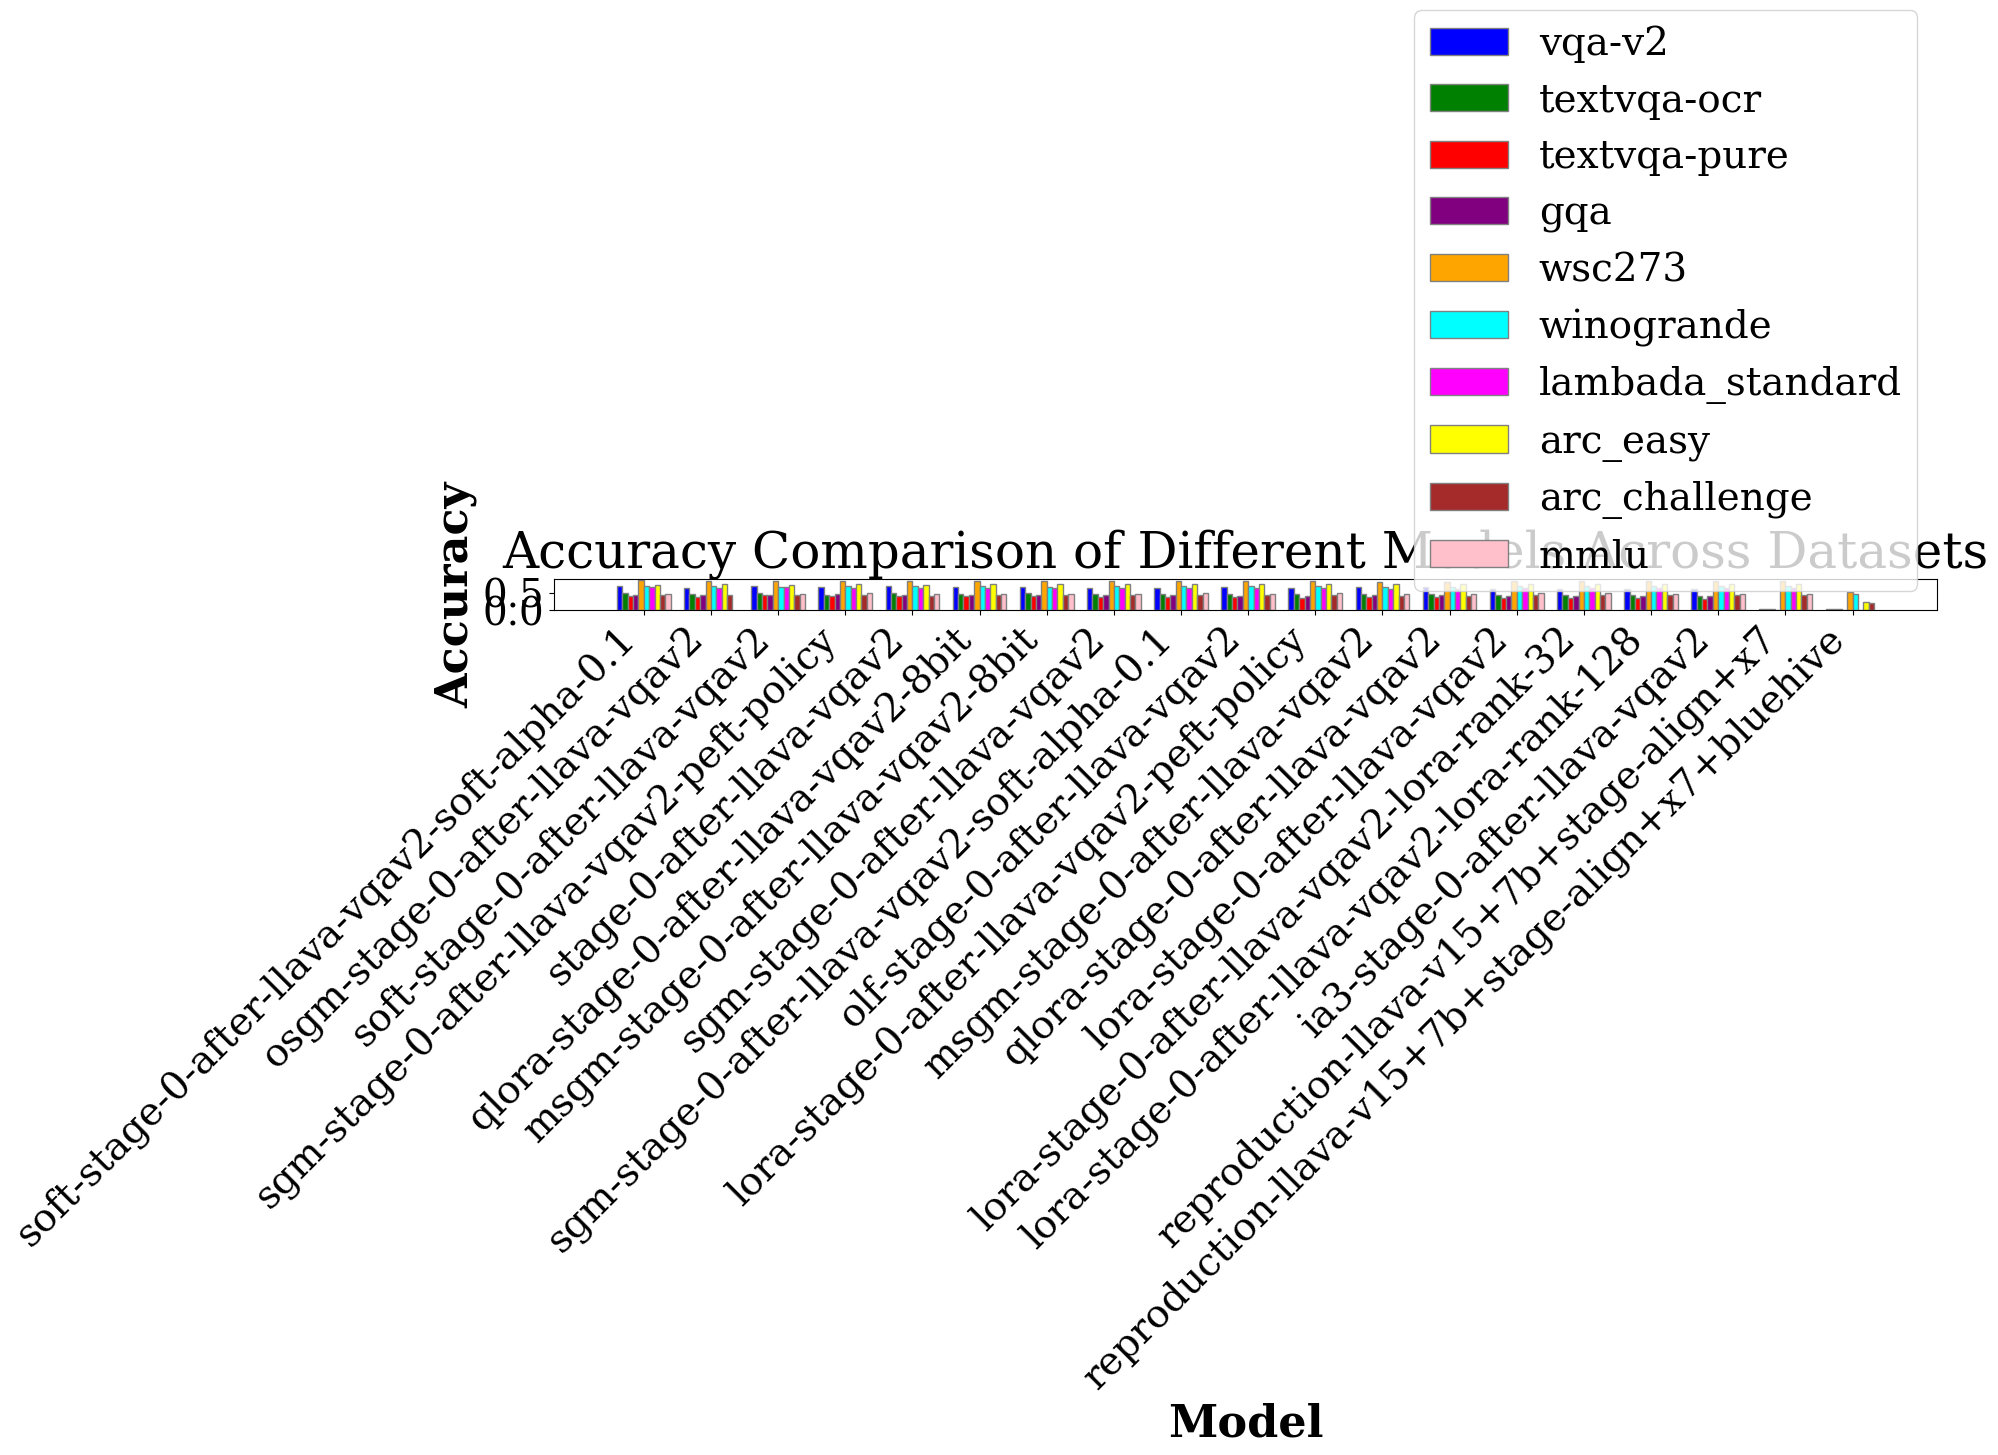

In [20]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the results data from the file
results_file = 'results_A.json'
with open(results_file, 'r') as f:
    result = json.load(f)

# Datasets of interest
datasets = [
    'vqa-v2', 'textvqa-ocr', 'textvqa-pure', 'gqa',
    'wsc273', 'winogrande', 'lambada_standard', 'arc_easy', 'arc_challenge', 'mmlu'
]

# Extract data for calculating average accuracy and sorting
model_accuracies = []

for model_name, metrics in result.items():
    accuracies = [metrics.get(dataset, np.nan) for dataset in datasets]
    # Calculate average accuracy, ignoring NaN values
    avg_accuracy = np.nanmean(accuracies)
    model_accuracies.append((model_name, accuracies, avg_accuracy))

# Sort models based on average accuracy
model_accuracies.sort(key=lambda x: x[2], reverse=True)

# Extract sorted data for plotting
models = [x[0] for x in model_accuracies]
sorted_accuracies = [x[1] for x in model_accuracies]

# Extract accuracies for each dataset
dataset_accuracies = {dataset: [accuracies[i] for accuracies in sorted_accuracies] for i, dataset in enumerate(datasets)}

# Define the bar width
bar_width = 0.08

# Set the positions of the bars on the x-axis
r = [np.arange(len(models))]
for i in range(1, len(datasets)):
    r.append([x + bar_width for x in r[i-1]])

# Create the plot
plt.figure(figsize=(20, 10))

# Create bars
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'brown', 'pink']
for i, dataset in enumerate(datasets):
    plt.bar(r[i], dataset_accuracies[dataset], color=colors[i % len(colors)], width=bar_width, edgecolor='grey', label=dataset)

# Add xticks on the middle of the group bars
plt.xlabel('Model', fontweight='bold')
plt.xticks([r + bar_width * (len(datasets) - 1) / 2 for r in range(len(models))], models, rotation=45, ha='right')

# Add labels
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Accuracy Comparison of Different Models Across Datasets')

# Create legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [21]:
import json
import numpy as np

# Define the list of models and the datasets of interest
models = ['soft', 'lora', 'qlora', 'msgm', 'sgm', 'ptune', 'prompt', 'ia3', 'naive-ft', 'vicuna', 'olf']
datasets = [
    'vqa-v2', 'textvqa-ocr', 'textvqa-pure', 'gqa',
    'wsc273', 'winogrande', 'lambada_standard', 'arc_easy', 'arc_challenge', 'mmlu'
]

results_file = 'results_A.json'
# Load the JSON data from the file
with open(results_file, 'r') as f:
    results = json.load(f)

# Initialize model mappings
model_mappings = {model: [] for model in models}

# Function to map model_name to category
def get_category(model_name):
    if 'reproduction' in model_name:
        return 'vicuna'
    if model_name.startswith('stage'):
        return 'naive-ft'
    for model in models:
        if model in ['msgm', 'sgm']:
            if 'msgm' in model_name:
                return 'msgm'
            if 'sgm' in model_name:
                return 'sgm'
        if model in model_name and not (model == 'lora' and 'qlora' in model_name):
            return model
    return None

# Populate the mappings based on model name rules
for model_name, metrics in results.items():
    # Ensure the model has all required datasets
    if all(dataset in metrics for dataset in datasets):
        category = get_category(model_name)
        if category:
            accuracies = list(metrics.values())
            avg_accuracy = np.nanmean(accuracies)
            model_mappings[category].append((model_name, avg_accuracy))
        else:
            for model in models:
                if model in model_name and not (model == 'lora' and 'qlora' in model_name):
                    model_mappings[model].append((model_name, np.nanmean(list(metrics.values()))))
    else:
        missing_datasets = [dataset for dataset in datasets if dataset not in metrics]
        print(f"Warning: Model '{model_name}' is missing datasets: {missing_datasets}")

# Identify the highest accuracy model for each mapping
highest_accuracy_models = {}
for model, mappings in model_mappings.items():
    if mappings:
        highest_accuracy_models[model] = max(mappings, key=lambda x: x[1])

# Save the highest accuracy models to a file
output_file = 'highest_accuracy_models.json'
with open(output_file, 'w') as f:
    json.dump(highest_accuracy_models, f, indent=2)

# Map the highest accuracy models to the new names
name_mapping = {
    'soft': 'Soft Targets',
    'msgm': 'mSGM',
    'sgm': 'SGM',
    'lora': 'LoRA',
    'qlora': 'QLoRA',
    'ia3': 'IA3',
    'prompt': 'Prompt Tuning',
    'ptune': 'P-Tuning',
    'naive-ft': 'LLaVA Naive-FT',
    'vicuna': 'Vicuna 1.5 7B',
    'olf': 'Output Layer Freezing'
}

# Prepare data for radar chart
methods = [name_mapping[model] for model in models if model in highest_accuracy_models]
results_dict = {}

for model in models:
    if model in highest_accuracy_models:
        model_name, _ = highest_accuracy_models[model]
        metrics = results[model_name]
        accuracies = {dataset: metrics.get(dataset, np.nan) for dataset in datasets}
        results_dict[name_mapping[model]] = accuracies

# Output the results dictionary
print(json.dumps(results_dict, indent=2))


{
  "Soft Targets": {
    "vqa-v2": 0.7028,
    "textvqa-ocr": 0.4987304687500001,
    "textvqa-pure": 0.4281250000000001,
    "gqa": 0.4551,
    "wsc273": 0.8608058608058609,
    "winogrande": 0.6921862667719021,
    "lambada_standard": 0.6782456821269164,
    "arc_easy": 0.7247474747474747,
    "arc_challenge": 0.4300341296928328,
    "mmlu": 0.4766415040592508
  },
  "LoRA": {
    "vqa-v2": 0.6491,
    "textvqa-ocr": 0.46474609375000026,
    "textvqa-pure": 0.36835937500000004,
    "gqa": 0.42579999999999996,
    "wsc273": 0.8461538461538461,
    "winogrande": 0.6945540647198106,
    "lambada_standard": 0.6483601785367747,
    "arc_easy": 0.7617845117845118,
    "arc_challenge": 0.43686006825938567,
    "mmlu": 0.48732374305654463
  },
  "QLoRA": {
    "vqa-v2": 0.6838,
    "textvqa-ocr": 0.4838867187500003,
    "textvqa-pure": 0.40126953125000014,
    "gqa": 0.4424,
    "wsc273": 0.8498168498168498,
    "winogrande": 0.6929755327545383,
    "lambada_standard": 0.6454492528624103,
 

Top 3 only